## Load dependencies

In [1]:
# %pip install -e ".."

In [1]:
# --- standard ---
import os
import sys
import time
from datetime import datetime
from pathlib import Path

# --- scientific ---
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LightSource
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage
from scipy.interpolate import RBFInterpolator
from scipy.spatial import cKDTree

# --- machine learning / preprocessing ---
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering

# --- geostatistics ---
import skgstat as skg
from skgstat import models
import gstatsim as gs

# --- image / geometry utilities ---
from skimage.measure import find_contours

# --- parallelization ---
from joblib import Parallel, delayed

# --- local utilities (custom colormap) ---
from multigrid_sgsim.utils import geosoft_cmap_k65
geosoft_cmap = geosoft_cmap_k65()
ls = LightSource(azdeg=120, altdeg=45)

# --- local multigrid SGSIM implementation ---
from multigrid_sgsim import mgsim, sampling, trendmaking
from multigrid_sgsim.utils import cluster_variogram


## Load and plot data

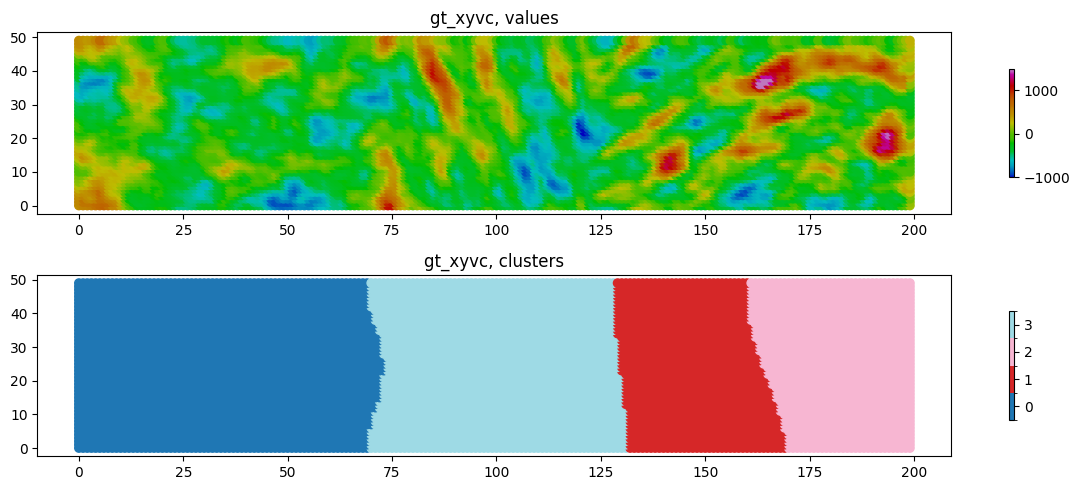

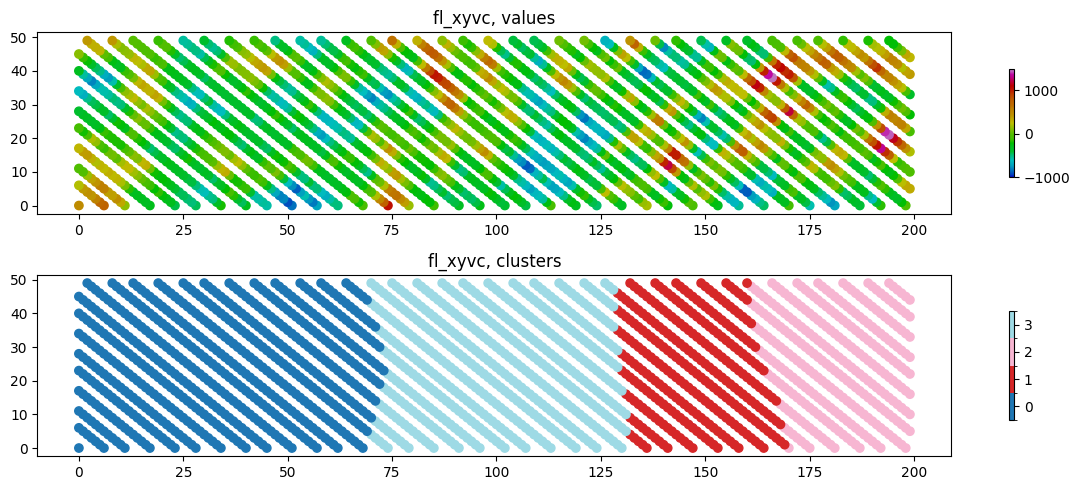

In [3]:
## LOAD AND PLOT GROUND TRUTH AND FLIGHTLINES ##
## ========================================== ##

# GROUND TRUTH
df_gt_xyvc = pd.read_csv("./data/gt_xyvc.csv")
gt_xyvc = df_gt_xyvc.values

# FLIGHT LINES
df_fl_xyvc = pd.read_csv("./data/fl_xyvc.csv")
fl_xyvc = df_fl_xyvc.values


# get number of clusters from gt_xyvc
regions = gt_xyvc[:, 3]
unique_regions = np.unique(regions)
n_regions = len(unique_regions)
# set plot characteristics based on region clustering from gt_xyvc
cmap = plt.colormaps["tab20"].resampled(n_regions)
norm = mcolors.BoundaryNorm(
    boundaries=np.arange(-0.5, n_regions+0.5, 1),
    ncolors=n_regions
)

# plot ground truth and clustering
plt.figure(figsize=(12,5))
plt.subplot(2, 1, 1)
plt.scatter(gt_xyvc[:,0], gt_xyvc[:,1], c=gt_xyvc[:,2], cmap=geosoft_cmap)
plt.title(f"gt_xyvc")
plt.colorbar(shrink=0.6)
plt.clim(-1000, 1500)
plt.title("gt_xyvc, values")
plt.subplot(2, 1, 2)
plt.scatter(gt_xyvc[:,0], gt_xyvc[:,1], c=gt_xyvc[:,3], cmap=cmap, norm=norm)
plt.title(f"gt_xyvc, clusters")
plt.colorbar(shrink=0.6, ticks=np.arange(n_regions))
plt.tight_layout()

# plot flight lines and clustering
plt.figure(figsize=(12,5))
plt.subplot(2, 1, 1)
plt.scatter(fl_xyvc[:,0], fl_xyvc[:,1], c=fl_xyvc[:,2], cmap=geosoft_cmap)
plt.title(f"fl_xyvc")
plt.colorbar(shrink=0.6)
plt.clim(-1000, 1500)
plt.title("fl_xyvc, values")
plt.subplot(2, 1, 2)
plt.scatter(fl_xyvc[:,0], fl_xyvc[:,1], c=fl_xyvc[:,3], cmap=cmap, norm=norm)
plt.title(f"fl_xyvc, clusters")
plt.colorbar(shrink=0.6, ticks=np.arange(n_regions))
plt.tight_layout()


## Make trend

In [3]:
## USE make_trend() TO MAKE A TREND ##
## ================================ ##

# define the grid and fl_xyvc
grid_xyc = np.column_stack([gt_xyvc[:, :2], gt_xyvc[:, 3]]) # isolate just the grid points and cluster id columns (get rid of values column)
fl_xyvc = fl_xyvc

# make the trend (note this will be different trend each time the function is called, due to sampling in the make_trend() function)
smoothing = 1.0
linespacing = 5
fl_xyvct, grid_xyct = trendmaking.make_trend(fl_xyvc, grid_xyc, smoothing, linespacing)



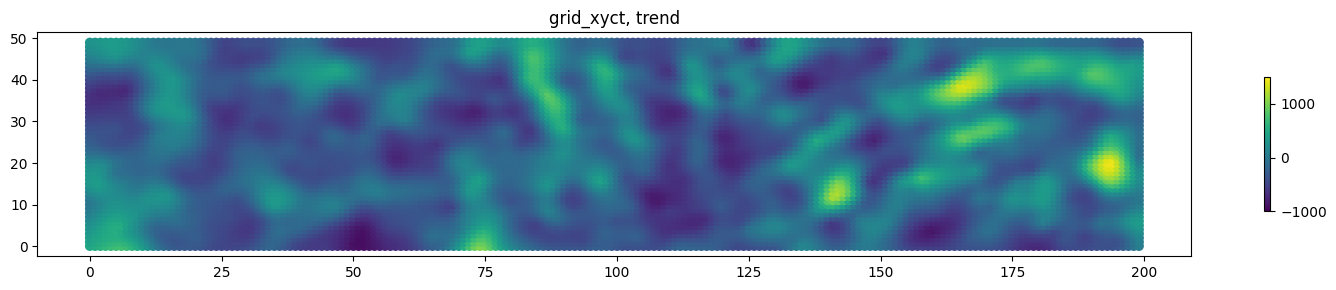

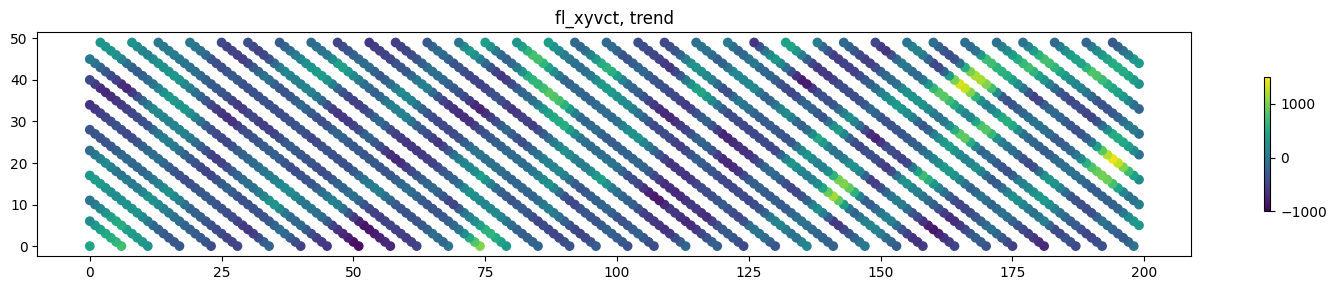

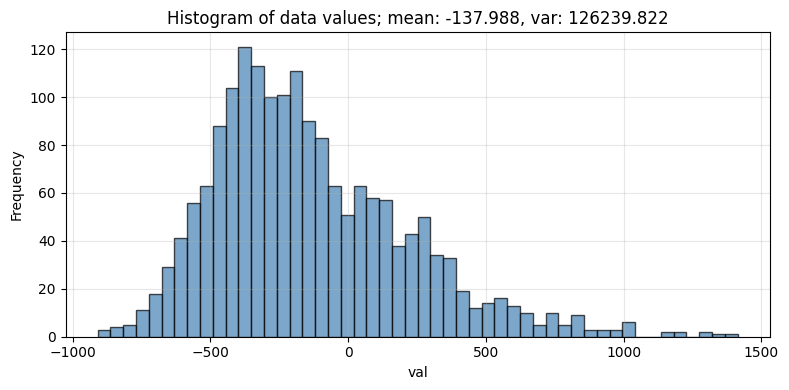

In [4]:
## PLOT TREND ##
## ========== ##

# plot trend on grid points
plt.figure(figsize=(15,3))
plt.scatter(grid_xyct[:,0], grid_xyct[:,1], c=grid_xyct[:,3])
plt.title(f"grid_xyct, trend")
plt.colorbar(shrink=0.6)
plt.clim(-1000, 1500)
plt.tight_layout()

# plot trend on observation points (flight lines)
plt.figure(figsize=(15,3))
plt.scatter(fl_xyvct[:,0], fl_xyvct[:,1], c=fl_xyvct[:,4])
plt.title(f"fl_xyvct, trend")
plt.colorbar(shrink=0.6)
plt.clim(-1000, 1500)
plt.tight_layout()

# Histogram of flightline data
plt.figure(figsize=(8, 4))
residuals = fl_xyvct[:, 4]
plt.hist(residuals, bins=50, color="steelblue", edgecolor="k", alpha=0.7)
plt.title(f"Histogram of data values; mean: {fl_xyvct[:,4].mean():.3f}, var: {fl_xyvct[:,4].var():.3f}")
plt.xlabel("val")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Compute residuals

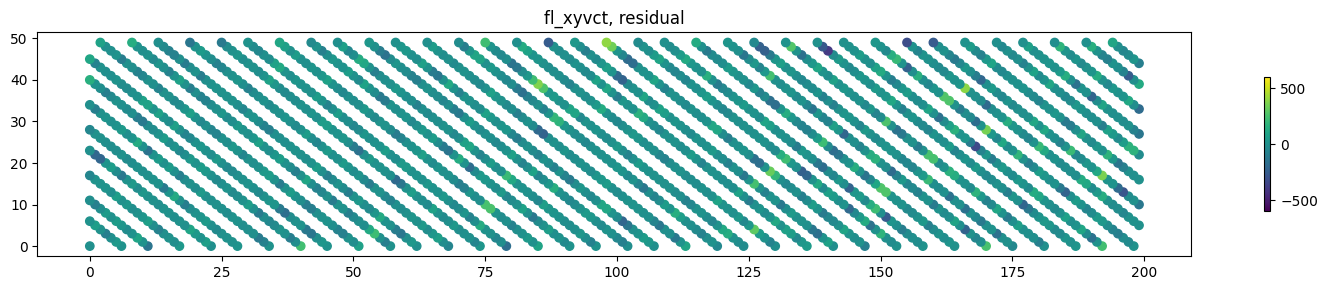

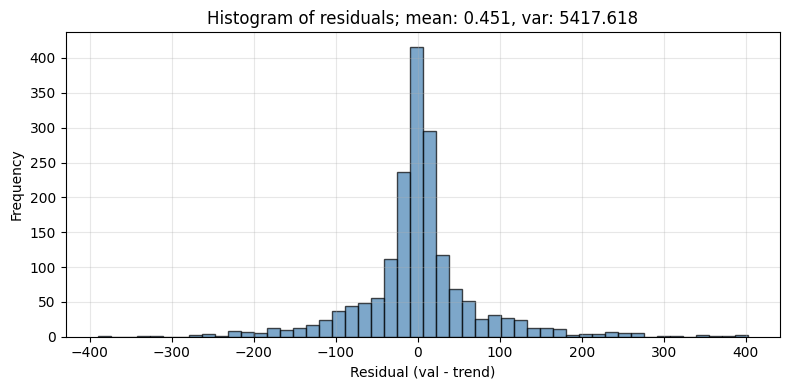

In [5]:
## COMPUTE RESIDUALS AND ADD TO ARRAY ##
## ================================== ##

# val is col 2, trend is col 4
residuals = fl_xyvct[:, 2] - fl_xyvct[:, 4]

# add as new column
fl_xyvctr = np.column_stack([fl_xyvct, residuals])

# plot residuals (only exist on observation points)
plt.figure(figsize=(15,3))
plt.scatter(fl_xyvctr[:,0], fl_xyvctr[:,1], c=fl_xyvctr[:,5])
plt.title(f"fl_xyvct, residual")
plt.colorbar(shrink=0.6)
plt.clim(-600, 600)
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 4))
residuals = fl_xyvctr[:, 5]
plt.hist(residuals, bins=50, color="steelblue", edgecolor="k", alpha=0.7)
plt.title(f"Histogram of residuals; mean: {fl_xyvctr[:,5].mean():.3f}, var: {fl_xyvctr[:,5].var():.3f}")
plt.xlabel("Residual (val - trend)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



## Create DataFrame for flightline information

In [6]:
## PACK FLIGHTLINE INFO AND GRID INFO INTO ##
##  DATAFRAMES FOR GStatSim COMPATIBILITY  ##
## ======================================= ##

df_fl_xyvctr = pd.DataFrame(
    fl_xyvctr,
    columns=["x", "y", "value", "cluster", "trend", "residual"]
)

df_grid_xyct = pd.DataFrame(
    grid_xyct,
    columns=["x", "y", "cluster", "trend"]
)

print("flightline DataFrame")
print(df_fl_xyvctr.head())
print("\ngrid DataFrame")
print(df_grid_xyct.head())


flightline DataFrame
      x    y       value  cluster       trend    residual
0   0.0  0.0  474.224075      0.0  476.001564   -1.777489
1   6.0  0.0  749.593665      0.0  738.563695   11.029970
2  11.0  0.0  131.113667      0.0  262.649654 -131.535987
3  17.0  0.0 -270.998116      0.0 -309.717487   38.719371
4  23.0  0.0 -432.319171      0.0 -426.544902   -5.774269

grid DataFrame
     x    y  cluster       trend
0  0.0  0.0      0.0  476.001564
1  1.0  0.0      0.0  528.076942
2  2.0  0.0      0.0  581.200658
3  3.0  0.0      0.0  632.441951
4  4.0  0.0      0.0  681.264862


In [7]:
## AUGMENT DATAFRAME TO INCLUDE OBSERVATION POINT SET INFORMATION ##
## ============================================================== ##

# --- config ---
xcol, ycol, vcol = "x", "y", "value"
tol = 1e-8  # tolerance to match obs to grid

# --- build KDTree to map flightline points -> grid nodes ---
grid_xy = df_grid_xyct[[xcol, ycol]].to_numpy()
obs_xy  = df_fl_xyvctr[[xcol, ycol]].to_numpy()
obs_val = df_fl_xyvctr[vcol].to_numpy()

tree = cKDTree(grid_xy)
dist, gi = tree.query(obs_xy, distance_upper_bound=tol)  # gi==len(grid_xy) if no match
valid = np.isfinite(dist) & (gi >= 0) & (gi < len(grid_xy))

# --- start from grid; create df_xyvtcs with desired columns and dtypes ---
df_xyvtcs = df_grid_xyct.copy()

# ensure required columns exist with appropriate dtypes
if "trend" not in df_xyvtcs.columns:
    df_xyvtcs["trend"] = np.nan
if "cluster" not in df_xyvtcs.columns:
    df_xyvtcs["cluster"] = np.nan

df_xyvtcs["set"] = np.zeros(len(df_xyvtcs), dtype=np.int8)  # replaces grd_obs

# 🔁 change: initialize non-observation points as NaN
df_xyvtcs[vcol] = np.nan  # ensures float dtype and NaNs for non-obs nodes

# --- handle duplicates: average obs that hit the same grid node ---
matched = pd.DataFrame({"grid_idx": gi[valid].astype(int), vcol: obs_val[valid]})
agg = matched.groupby("grid_idx", as_index=False)[vcol].mean()

# --- assign values and flags ---
df_xyvtcs.loc[agg["grid_idx"].values, vcol] = agg[vcol].values
df_xyvtcs.loc[agg["grid_idx"].values, "set"] = 1

# --- reorder columns: x, y, value, trend, cluster, set (keep any extras after) ---
first = [xcol, ycol, vcol, "trend", "cluster", "set"]
rest = [c for c in df_xyvtcs.columns if c not in first]
df_xyvtcs = df_xyvtcs.loc[:, first + rest]

# --- (optional) report ---
print(f"Obs points total: {len(obs_xy)}")
print(f"Matched to grid within tol: {valid.sum()}")
print(f"Grid nodes updated (deduped): {len(agg)}")
print(f"Unmatched obs: {len(obs_xy) - valid.sum()}")

df_xyvtcs


Obs points total: 1767
Matched to grid within tol: 1767
Grid nodes updated (deduped): 1767
Unmatched obs: 0


,x,y,value,trend,cluster,set
0,0.0,0.0,474.224075,476.001564,0.0,1
1,1.0,0.0,NaN,528.076942,0.0,0
2,2.0,0.0,NaN,581.200658,0.0,0
3,3.0,0.0,NaN,632.441951,0.0,0
4,4.0,0.0,NaN,681.264862,0.0,0
...,...,...,...,...,...,...
9995,195.0,49.0,NaN,-372.602403,2.0,0
9996,196.0,49.0,NaN,-392.385157,2.0,0
9997,197.0,49.0,NaN,-388.210474,2.0,0
9998,198.0,49.0,NaN,-371.299091,2.0,0


## Define variogram per cluster

In [8]:
## BUILD CLUSTER-SPECIFIC THEORETICAL VARIOGRAMS ##
## ============================================= ##

# set max lag and number of lags
maxlag = 40
n_lags = 20

# compute cluster-specific variograms for each region
# NOTE: V0.parameters is [range, sill, nugget]
value_or_residual = 'residual'
V0 = cluster_variogram(df_fl_xyvctr, value_or_residual, 0, maxlag, n_lags)
V1 = cluster_variogram(df_fl_xyvctr, value_or_residual, 1, maxlag, n_lags)
V2 = cluster_variogram(df_fl_xyvctr, value_or_residual, 2, maxlag, n_lags)
V3 = cluster_variogram(df_fl_xyvctr, value_or_residual, 3, maxlag, n_lags)


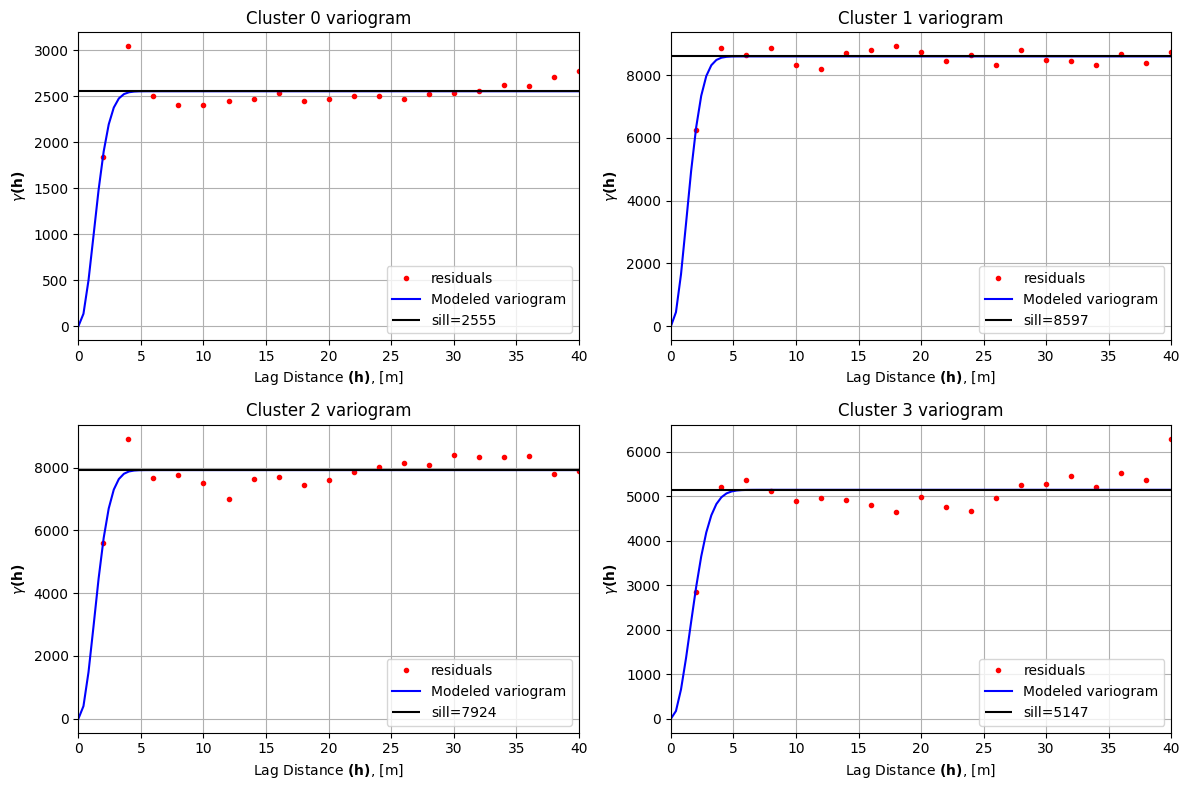

In [9]:
## PLOT CLUSTER-SPECIFIC VARIOGRAMS ##
## ================================ ##

# FIT THEORETICAL VARIOGRAMS

# model used in fit
vtype = 'gaussian'
V0.model = vtype
V1.model = vtype
V2.model = vtype
V3.model = vtype 

# create array of evenly spaced lag values to evaluate
n = 100
lagh = np.linspace(0,40,n)

range0 = V0.parameters[0]; sill0 = V0.parameters[1]; nug0 = V0.parameters[2]
range1 = V1.parameters[0]; sill1 = V1.parameters[1]; nug1 = V1.parameters[2]
range2 = V2.parameters[0]; sill2 = V2.parameters[1]; nug2 = V2.parameters[2]
range3 = V3.parameters[0]; sill3 = V3.parameters[1]; nug3 = V3.parameters[2]

y0 = [models.gaussian(h, range0, sill0, nug0) for h in lagh]
y1 = [models.gaussian(h, range1, sill1, nug1) for h in lagh]
y2 = [models.gaussian(h, range2, sill2, nug2) for h in lagh]
y3 = [models.gaussian(h, range3, sill3, nug3) for h in lagh]

variograms = [V0, V1, V2, V3]
ys = [y0, y1, y2, y3]

# PLOT (2x2 layout)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid
axs = axs.flatten()  # flatten to 1D for iteration

for i, (ax, V, y) in enumerate(zip(axs, variograms, ys)):
    ax.plot(V.bins, V.experimental, '.', color='red', label='residuals')
    ax.plot(lagh, y, '-', color='blue', label='Modeled variogram')
    ax.hlines(y=V.parameters[1], xmin=0, xmax=40,
              color='black', label=f"sill={V.parameters[1]:.0f}")
    ax.set_xlabel(r'Lag Distance $\bf(h)$, [m]')
    ax.set_ylabel(r'$\gamma \bf(h)$')
    ax.set_title(f'Cluster {i} variogram')
    ax.legend(loc='lower right')
    ax.set_xlim([0, 40])
    ax.grid(True)

plt.tight_layout()
plt.show()



In [10]:
## CREATE VARIOGRAM DATAFRAME ##
## ========================== ##

azimuth = 0
# NOTE: gam = [azimuth, nugget, major_range, minor_range, sill, variogram_type]
gam0 = [azimuth, nug0, range0, range0, sill0, vtype]
gam1 = [azimuth, nug1, range1, range1, sill1, vtype]
gam2 = [azimuth, nug2, range2, range2, sill2, vtype]
gam3 = [azimuth, nug3, range3, range3, sill3, vtype]

df_gamma = pd.DataFrame({'Variogram': [gam0, gam1, gam2, gam3]})
df_gamma


,Variogram
0,"[0, 0, 3.46365299596472, 3.46365299596472, 255..."
1,"[0, 0, 3.4945451409002892, 3.4945451409002892,..."
2,"[0, 0, 3.5464327771604016, 3.5464327771604016,..."
3,"[0, 0, 4.36223817587848, 4.36223817587848, 514..."


## Run multigrid simulation (one realization)

In [11]:
## RUN MGSIM ##
## ========= ##

mg_resols = [20,10,5,4,3,2,1] #[pixels]
df_grid = df_xyvtcs
df_mgsim = mgsim(mg_resols, df_grid, df_gamma, xx='x', yy='y', zz='residual', kk='cluster', num_points=10, radius=40)

MultiGrid iteration 1: Processing resolution 20


100%|██████████| 10000/10000 [00:29<00:00, 342.19it/s]


MultiGrid iteration 2: Processing resolution 10


100%|██████████| 10000/10000 [00:29<00:00, 344.01it/s]


MultiGrid iteration 3: Processing resolution 5


100%|██████████| 10000/10000 [00:27<00:00, 360.96it/s]


MultiGrid iteration 4: Processing resolution 4


100%|██████████| 10000/10000 [00:27<00:00, 367.04it/s]


MultiGrid iteration 5: Processing resolution 3


100%|██████████| 10000/10000 [00:27<00:00, 367.67it/s]


MultiGrid iteration 6: Processing resolution 2


100%|██████████| 10000/10000 [00:24<00:00, 402.38it/s]


MultiGrid iteration 7: Processing resolution 1


100%|██████████| 10000/10000 [00:25<00:00, 396.61it/s]


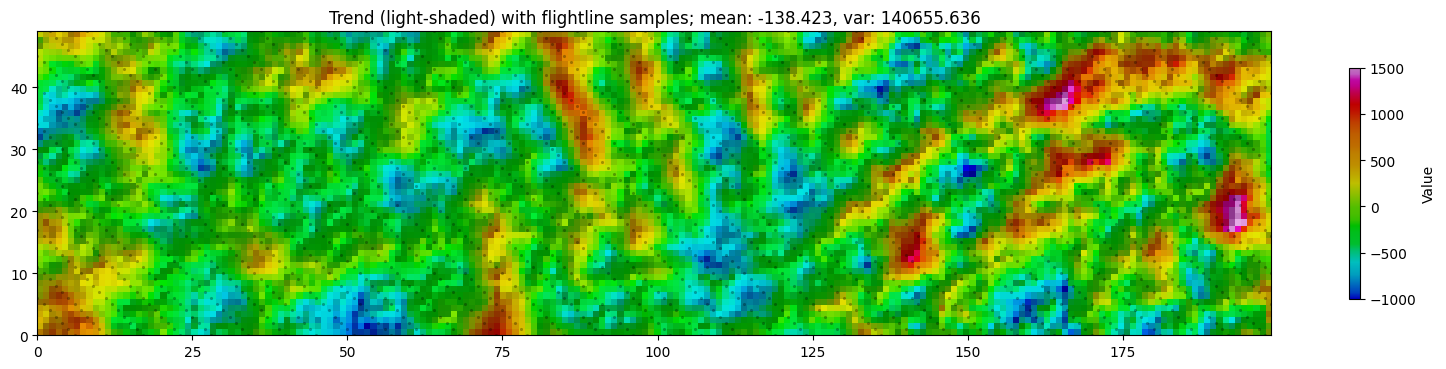

In [29]:
## ======================== ##
## PLOT REALIZATION EXAMPLE ##
## ======================== ##

x_coords = df_mgsim['x'].values
y_coords = df_mgsim['y'].values
values = df_mgsim['newtrend'].values

rows, cols = 50, 200

x_mat = x_coords.reshape((rows, cols))
y_mat = y_coords.reshape((rows, cols))
mat = values.reshape((rows, cols))


# --- grid + data you already have ---
# x_coords, y_coords, values (1D); mat is values.reshape((rows, cols))

# --- extent from coords (so imshow aligns to your x/y units) ---
xmin, xmax = float(x_coords.min()), float(x_coords.max())
ymin, ymax = float(y_coords.min()), float(y_coords.max())
extent = [xmin, xmax, ymin, ymax]

# --- light shading params + colormap range ---
vmin, vmax = -1000, 1500
ls = LightSource(azdeg=45, altdeg=45)  # tweak if you want
rgb_trend = ls.shade(mat, cmap=geosoft_cmap, blend_mode='soft', vmin=vmin, vmax=vmax)

# --- mappable for colorbar (must match vmin/vmax + cmap used in shade) ---
mappable = ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap=geosoft_cmap)
mappable.set_array([])

fl_x, fl_y = fl_xyvct[:, 0], fl_xyvct[:, 1]

# --- plot ---
fig, ax = plt.subplots(figsize=(16, 8))

# background grid (hillshaded raster)
ax.imshow(rgb_trend, origin='lower', extent=extent)

# overlay flightline points
ax.scatter(
    fl_x, fl_y,
    s=5, c='k', alpha=0.3,  # semi-transparent black dots
    linewidths=0, rasterized=True
)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title(
    f"Trend (light-shaded) with flightline samples; "
    f"mean: {np.nanmean(values):.3f}, var: {np.nanvar(values):.3f}"
)

fig.colorbar(mappable, ax=ax, shrink=0.3, label="Value")
plt.tight_layout()
plt.show()